In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split

/Users/MyDinh/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data Cleaning & Feature Engineering

In [2]:
df_train = pd.read_csv("houseprice.csv")
df_val = pd.read_csv("test.csv")
df_train['TotalSquareFootage'] = df_train['GrLivArea'] + df_train['TotalBsmtSF']
df_train['Price Per Square Foot'] = df_train['SalePrice']/df_train['TotalSquareFootage']
price = df_train['Price Per Square Foot']
df = df_train.drop(['SalePrice', 'Price Per Square Foot'], axis = 1)


In [3]:
#check if there is any missing value in any column: 
#as we see, most of the columns with missing value correspond to categorical values. 
null_col = df.isnull().sum()


In [3]:
#fix missing value
for i in df.columns:
    df[i] = df[i].fillna("no_present")
##Adding columns that more meaningful:

df['if_remodel'] = df['YearRemodAdd']- df['YearBuilt']
df.loc[df['YearRemodAdd']-df['YearBuilt'] !=0, 'if_remodel']= '1'
df.loc[df['YearRemodAdd']-df['YearBuilt'] ==0, 'if_remodel']= '0'
df.loc[df['MiscVal'] >= 200, 'Addition_feature'] = '1'
df.loc[df['MiscVal'] < 200, 'Addition_feature'] = '0'
#Adding columns that calculate the age of the house
df['Age']= df['YrSold'] - df['YearBuilt']
#Dropping insignificant Catergorical Coluumn
df.drop(['MiscFeature', 'MiscVal', 'YearBuilt','BsmtFinType2','BsmtFinSF2','GarageCond','HouseStyle','BsmtCond','Exterior2nd','BsmtCond','BsmtExposure','BsmtUnfSF','Heating','Id'], axis =1, inplace = True)

##Simplyfying Catergorical variables value: 

df.ix[(df['OverallQual']>=7) & (df['OverallQual']<=10), 'OverallQual']= 0
df.ix[(df['OverallQual']>=4) & (df['OverallQual']<=3), 'OverallQual']= 1
df.ix[(df['OverallQual']>=1) & (df['OverallQual']<=2), 'OverallQual']= 2
df.ix[(df['OverallCond']>=7) & (df['OverallCond']<=10), 'OverallCond']= 0
df.ix[(df['OverallCond']>=4) & (df['OverallCond']<=3), 'OverallCond']= 1
df.ix[(df['OverallCond']>=1) & (df['OverallCond']<=2), 'OverallCond']= 2

df.ix[(df['GarageQual']== 'Ex') | (df['GarageQual']== 'Gd') , 'GarageQual']=0
df.ix[(df['GarageQual']== 'Fa') |(df['GarageQual']== 'TA'), 'GarageQual']=1
df.ix[(df['GarageQual']== 'Po')|(df['GarageQual']== 'no_present') , 'GarageQual']=2
df.ix[(df['PoolQC']== 'Ex') | (df['PoolQC']== 'Gd') , 'PoolQC']=0
df.ix[(df['PoolQC']== 'Fa') |(df['PoolQC']== 'TA'), 'PoolQC']=1
df.ix[(df['PoolQC']== 'Po')|(df['PoolQC']== 'no_present') , 'PoolQC']=2
df.ix[(df['ExterQual']== 'Ex') | (df['ExterQual']== 'Gd') , 'ExterQual']=0
df.ix[(df['ExterQual']== 'Fa') |(df['ExterQual']== 'TA'), 'ExterQual']=1
df.ix[(df['ExterQual']== 'Po')|(df['ExterQual']== 'no_present') , 'ExterQual']=2
df.ix[(df['BsmtQual']== 'Ex') | (df['BsmtQual']== 'Gd') , 'BsmtQual']=0
df.ix[(df['BsmtQual']== 'Fa') |(df['BsmtQual']== 'TA'), 'BsmtQual']=1
df.ix[(df['BsmtQual']== 'Po')|(df['BsmtQual']== 'no_present') , 'BsmtQual']=2
df.ix[(df['HeatingQC']== 'Ex') | (df['HeatingQC']== 'Gd') , 'HeatingQC']=0
df.ix[(df['HeatingQC']== 'Fa') |(df['HeatingQC']== 'TA'), 'HeatingQC']=1
df.ix[(df['HeatingQC']== 'Po')|(df['HeatingQC']== 'no_present') , 'HeatingQC']=2
df.ix[(df['KitchenQual']== 'Ex') | (df['KitchenQual']== 'Gd') , 'KitchenQual']=0
df.ix[(df['KitchenQual']== 'Fa') |(df['KitchenQual']== 'TA'), 'KitchenQual']=1
df.ix[(df['KitchenQual']== 'Po')|(df['KitchenQual']== 'no_present') , 'KitchenQual']=2
df.ix[(df['FireplaceQu']== 'Ex') | (df['FireplaceQu']== 'Gd') , 'FireplaceQu']=0
df.ix[(df['FireplaceQu']== 'Fa') |(df['FireplaceQu']== 'TA'), 'FireplaceQu']=1
df.ix[(df['FireplaceQu']== 'Po')|(df['FireplaceQu']== 'no_present') , 'FireplaceQu']=2
#Grouping values in Lot Shape: 
df.ix[(df['LotShape']== 'Reg') | (df['LotShape']== 'IR1') , 'LotShape']=0
df.ix[(df['LotShape']== 'IR1') | (df['LotShape']== 'IR2') , 'LotShape']=1
#Grouping valaues in Condition 1 &2: 
df.ix[(df['Condition1']== 'Artery') | (df['Condition1']== 'Feedr') , 'Condition1']=0
df.ix[df['Condition1']== 'Norm','Condition1']= 1
df.ix[(df['Condition1']== 'RRNn') | (df['Condition1']== 'RRAn') , 'Condition1']=2
df.ix[(df['Condition1']== 'PosN') | (df['Condition1']== 'PosA') , 'Condition1']=3
df.ix[(df['Condition1']== 'RRNe') | (df['Condition1']== 'RRAe') , 'Condition1']=4

df.ix[(df['Condition2']== 'Artery') | (df['Condition2']== 'Feedr') , 'Condition2']=0
df.ix[(df['Condition2']== 'Artery') | (df['Condition2']== 'Feedr') , 'Condition2']=0
df.ix[(df['Condition2']== 'RRNn') | (df['Condition2']== 'RRAn') , 'Condition2']=2
df.ix[(df['Condition2']== 'PosN') | (df['Condition2']== 'PosA') , 'Condition2']=3
df.ix[(df['Condition2']== 'RRNe') | (df['Condition2']== 'RRAe') , 'Condition2']=4
df.ix[df['SaleCondition']== 'Normal', 'SaleCondition']=0
df.ix[(df['SaleCondition']== 'Abnorml')|(df['SaleCondition']== 'AdjLand')|(df['SaleCondition']== 'Alloca')|(df['SaleCondition']== 'Family')|(df['SaleCondition']== 'Partial'), 'SaleCondition']=0

df.RoofStyle = (df.RoofStyle == "Gable").astype(int) 
df.RoofMatl = (df.RoofMatl == "CompShg").astype(int) 
df.Electrical = (df.Electrical == "SBrkr").astype(int)
df.Functional = (df.Functional == "Typ").astype(int)

In [5]:
# #dropping outliers
# #inspired by kernel that used statsmodel to detect outliers

# o=[30,462,523,632,968,970, 1298, 1324]

# df=df.drop(o,axis=0)
# price = price.drop(o,axis=0)
# df_val=df_val.drop(o,axis=0)


In [4]:
#Since I coudln't get above code to work,I just randomly pick few categorical variable

df = pd.get_dummies(df,columns=['MSSubClass','LandContour','MSZoning','LotShape','Neighborhood'],drop_first=True)

In [7]:

df.shape

(1460, 113)

In [5]:
df = df.select_dtypes(include=['Float64', 'Int64'])


In [9]:
df.shape

(1460, 81)

In [6]:
pca = PCA(35)
X_pca = pca.fit(df)
# print(df.columns)
# print(X_pca.components_)
pca_transform = np.dot(X_pca.components_, df.T)
pca_transform.shape

(35, 1460)

In [12]:
X_pca.components_.shape

(35, 81)

(35, 1460) [[  8.56539472e+03   9.71778990e+03   1.13678706e+04 ...,   9.19212173e+03
    9.80856121e+03   1.00528592e+04]
 [  3.21029485e+03   3.11439681e+03   3.25677035e+03 ...,   4.27383143e+03
    2.45148534e+03   3.05417411e+03]
 [ -4.58924480e+02   6.66152816e+02  -5.59019212e+02 ...,  -9.08262794e+02
    2.30927755e+02   5.98596309e+02]
 ..., 
 [  1.54099836e+01   1.58192482e+01   1.54198422e+01 ...,   1.65270727e+01
    1.55778306e+01   1.57803944e+01]
 [  1.36924856e+01   1.34874553e+01   1.36555352e+01 ...,   1.33179330e+01
    1.39962076e+01   1.35169619e+01]
 [  4.64938610e+00   4.75806533e+00   4.83279957e+00 ...,   4.79139904e+00
    5.09926439e+00   5.06288434e+00]]


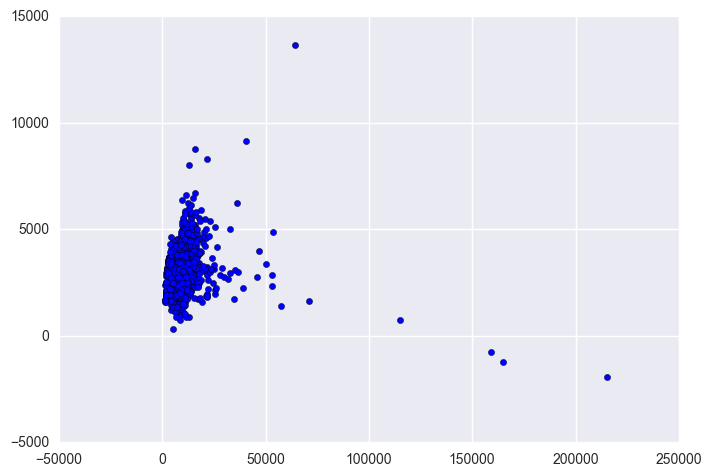

                              OLS Regression Results                             
Dep. Variable:     Price Per Square Foot   R-squared:                       0.980
Model:                               OLS   Adj. R-squared:                  0.980
Method:                    Least Squares   F-statistic:                     2005.
Date:                   Tue, 06 Jun 2017   Prob (F-statistic):               0.00
Time:                           05:23:44   Log-Likelihood:                -5445.9
No. Observations:                   1460   AIC:                         1.096e+04
Df Residuals:                       1425   BIC:                         1.115e+04
Df Model:                             35                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0001 

In [7]:
print(pca_transform.shape, pca_transform)
plt.scatter(pca_transform[0], pca_transform[1])
plt.show()
clf = sm.OLS(price, pca_transform.T)
result = clf.fit()
print(result.summary())

In [8]:
price.shape

(1460,)

In [10]:
pca_transform.T.shape

(1460, 35)

In [11]:
df_val['TotalSquareFootage'] = df_train['GrLivArea'] + df_train['TotalBsmtSF']


In [19]:
df.tail()

,LotArea,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,BsmtFinSF1,TotalBsmtSF,Electrical,1stFlrSF,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
1455,7917,6,5,2000,1,1,0,953,1,953,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1456,13175,6,6,1988,1,1,790,1542,1,2073,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1457,9042,0,0,2006,1,1,275,1152,1,1188,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1458,9717,5,6,1996,0,1,49,1078,0,1078,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1459,9937,5,6,1965,1,1,830,1256,1,1256,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:

#fix missing value
for i in df_val.columns:
    df_val[i] = df_val[i].fillna("0")
##Adding columns that more meaningful:

df_val['if_remodel'] = df_val['YearRemodAdd']- df_val['YearBuilt']
df_val.loc[df_val['YearRemodAdd']-df_val['YearBuilt'] !=0, 'if_remodel']= '1'
df_val.loc[df_val['YearRemodAdd']-df_val['YearBuilt'] ==0, 'if_remodel']= '0'
df_val.loc[df_val['MiscVal'] >= 200, 'Addition_feature'] = '1'
df_val.loc[df_val['MiscVal'] < 200, 'Addition_feature'] = '0'
#Adding columns that calculate the age of the house
df_val['Age']= df_val['YrSold'] - df_val['YearBuilt']
#Dropping insignificant Catergorical Coluumn
df_val.drop(['MiscFeature', 'MiscVal', 'YearBuilt','BsmtFinType2','BsmtFinSF2','GarageCond','HouseStyle','BsmtCond','Exterior2nd','BsmtCond','BsmtExposure','BsmtUnfSF','Heating','Id'], axis =1, inplace = True)


##Simplyfying Catergorical variables value: 

df_val.ix[(df_val['OverallQual']>=7) & (df_val['OverallQual']<=10), 'OverallQual']= 0
df_val.ix[(df_val['OverallQual']>=4) & (df_val['OverallQual']<=3), 'OverallQual']= 1
df_val.ix[(df_val['OverallQual']>=1) & (df_val['OverallQual']<=2), 'OverallQual']= 2
df_val.ix[(df_val['OverallCond']>=7) & (df_val['OverallCond']<=10), 'OverallCond']= 0
df_val.ix[(df_val['OverallCond']>=4) & (df_val['OverallCond']<=3), 'OverallCond']= 1
df_val.ix[(df_val['OverallCond']>=1) & (df_val['OverallCond']<=2), 'OverallCond']= 2
df_val.ix[(df_val['GarageQual']== 'Ex') | (df_val['GarageQual']== 'Gd') , 'GarageQual']=0
df_val.ix[(df_val['GarageQual']== 'Fa') |(df_val['GarageQual']== 'TA'), 'GarageQual']=1
df_val.ix[(df_val['GarageQual']== 'Po')|(df_val['GarageQual']== 'no_present') , 'GarageQual']=2
df_val.ix[(df_val['PoolQC']== 'Ex') | (df_val['PoolQC']== 'Gd') , 'PoolQC']=0
df_val.ix[(df_val['PoolQC']== 'Fa') |(df_val['PoolQC']== 'TA'), 'PoolQC']=1
df_val.ix[(df_val['PoolQC']== 'Po')|(df_val['PoolQC']== 'no_present') , 'PoolQC']=2
df_val.ix[(df_val['ExterQual']== 'Ex') | (df_val['ExterQual']== 'Gd') , 'ExterQual']=0
df_val.ix[(df_val['ExterQual']== 'Fa') |(df_val['ExterQual']== 'TA'), 'ExterQual']=1
df_val.ix[(df_val['ExterQual']== 'Po')|(df_val['ExterQual']== 'no_present') , 'ExterQual']=2
df_val.ix[(df_val['BsmtQual']== 'Ex') | (df_val['BsmtQual']== 'Gd') , 'BsmtQual']=0
df_val.ix[(df_val['BsmtQual']== 'Fa') |(df_val['BsmtQual']== 'TA'), 'BsmtQual']=1
df_val.ix[(df_val['BsmtQual']== 'Po')|(df_val['BsmtQual']== 'no_present') , 'BsmtQual']=2
df_val.ix[(df_val['HeatingQC']== 'Ex') | (df_val['HeatingQC']== 'Gd') , 'HeatingQC']=0
df_val.ix[(df_val['HeatingQC']== 'Fa') |(df_val['HeatingQC']== 'TA'), 'HeatingQC']=1
df_val.ix[(df_val['HeatingQC']== 'Po')|(df_val['HeatingQC']== 'no_present') , 'HeatingQC']=2
df_val.ix[(df_val['KitchenQual']== 'Ex') | (df_val['KitchenQual']== 'Gd') , 'KitchenQual']=0
df_val.ix[(df_val['KitchenQual']== 'Fa') |(df_val['KitchenQual']== 'TA'), 'KitchenQual']=1
df_val.ix[(df_val['KitchenQual']== 'Po')|(df_val['KitchenQual']== 'no_present') , 'KitchenQual']=2
df_val.ix[(df_val['FireplaceQu']== 'Ex') | (df_val['FireplaceQu']== 'Gd') , 'FireplaceQu']=0
df_val.ix[(df_val['FireplaceQu']== 'Fa') |(df_val['FireplaceQu']== 'TA'), 'FireplaceQu']=1
df_val.ix[(df_val['FireplaceQu']== 'Po')|(df_val['FireplaceQu']== 'no_present') , 'FireplaceQu']=2
#Grouping values in Lot Shape: 
df_val.ix[(df_val['LotShape']== 'Reg') | (df_val['LotShape']== 'IR1') , 'LotShape']=0
df_val.ix[(df_val['LotShape']== 'IR1') | (df_val['LotShape']== 'IR2') , 'LotShape']=1
#Grouping valaues in Condition 1 &2: 
df_val.ix[(df_val['Condition1']== 'Artery') | (df_val['Condition1']== 'Feedr') , 'Condition1']=0
df_val.ix[df_val['Condition1']== 'Norm','Condition1']= 1
df_val.ix[(df_val['Condition1']== 'RRNn') | (df_val['Condition1']== 'RRAn') , 'Condition1']=2
df_val.ix[(df_val['Condition1']== 'PosN') | (df_val['Condition1']== 'PosA') , 'Condition1']=3
df_val.ix[(df_val['Condition1']== 'RRNe') | (df_val['Condition1']== 'RRAe') , 'Condition1']=4

df_val.ix[(df_val['Condition2']== 'Artery') | (df_val['Condition2']== 'Feedr') , 'Condition2']=0
df_val.ix[(df_val['Condition2']== 'Artery') | (df_val['Condition2']== 'Feedr') , 'Condition2']=0
df_val.ix[(df_val['Condition2']== 'RRNn') | (df_val['Condition2']== 'RRAn') , 'Condition2']=2
df_val.ix[(df_val['Condition2']== 'PosN') | (df_val['Condition2']== 'PosA') , 'Condition2']=3
df_val.ix[(df_val['Condition2']== 'RRNe') | (df_val['Condition2']== 'RRAe') , 'Condition2']=4
df_val.ix[df_val['SaleCondition']== 'Normal', 'SaleCondition']=0
df_val.ix[(df_val['SaleCondition']== 'Abnorml')|(df_val['SaleCondition']== 'AdjLand')|(df_val['SaleCondition']== 'Alloca')|(df_val['SaleCondition']== 'Family')|(df_val['SaleCondition']== 'Partial'), 'SaleCondition']=0
df_val.RoofStyle = (df_val.RoofStyle == "Gable").astype(int) 
df_val.RoofMatl = (df_val.RoofMatl == "CompShg").astype(int) 
df_val.Electrical = (df_val.Electrical == "SBrkr").astype(int)
df_val.Functional = (df_val.Functional == "Typ").astype(int)
df_val = pd.get_dummies(df_val,columns=['MSSubClass','LandContour','MSZoning','LotShape','Neighborhood'],drop_first=True)



In [20]:
df_val.shape

(1459, 81)

In [13]:
#df_val[['BsmtFinSF1', 'TotalBsmtSF','GarageCars','GarageArea']] = df_val[['BsmtFinSF1', 'TotalBsmtSF','GarageCars','GarageArea']].astype(float)

df_val['BsmtFinSF1']=df_val['BsmtFinSF1'].astype(float)
df_val['TotalBsmtSF'] = df_val['TotalBsmtSF'].astype(float)
df_val['GarageCars'] = df_val['GarageCars'].astype(float)
df_val['GarageArea'] = df_val['GarageArea'].astype(float)
df_val['BsmtFullBath'] = df_val['BsmtFullBath'].astype(float)
df_val['BsmtHalfBath'] = df_val['BsmtHalfBath'].astype(float)


In [14]:
df_val = df_val.select_dtypes(include=['Float64', 'Int64'])

df_val = df_val.drop(['MSSubClass_150','MSZoning_C (all)'], axis =1)

In [16]:
pca_transform_test.T.shape

(1459, 35)

In [15]:
#problem doesn't match because during data cleaning,
#when making dummies values for catergorical variables, the number of cols doesn't match
#

pca_transform_test = np.dot(X_pca.components_, df_val.T)
preds = result.predict(pca_transform_test.T)




In [179]:
final = preds * df_val['TotalSquareFootage']

In [180]:
with open("output1.csv", "w") as fout:
    fout.write("Id,SalePrice\n")
    count = 1461
    for p in final:
        fout.write(str(count)+","+str(p)+"\n")
        count += 1

# Data Visualization

In [144]:
df.describe()

,LotArea,OverallQual,OverallCond,YearRemodAdd,RoofStyle,RoofMatl,BsmtFinSF1,TotalBsmtSF,Electrical,1stFlrSF,...,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.00000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,10516.828082,3.262329,4.063014,1984.865753,0.781507,0.982192,443.639726,1057.429452,0.913699,1162.626712,...,0.028082,0.05274,0.077397,0.017123,0.050685,0.040411,0.058904,0.017123,0.026027,0.007534
std,9981.264932,2.605752,2.135923,20.645407,0.413365,0.132299,456.098091,438.705324,0.280905,386.587738,...,0.165264,0.22359,0.267312,0.129775,0.219429,0.196989,0.235526,0.129775,0.159271,0.086502
min,1300.000000,0.000000,0.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7553.500000,0.000000,4.000000,1967.000000,1.000000,1.000000,0.000000,795.750000,1.000000,882.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9478.500000,5.000000,5.000000,1994.000000,1.000000,1.000000,383.500000,991.500000,1.000000,1087.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,11601.500000,6.000000,5.000000,2004.000000,1.000000,1.000000,712.250000,1298.250000,1.000000,1391.250000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,215245.000000,6.000000,6.000000,2010.000000,1.000000,1.000000,5644.000000,6110.000000,1.000000,4692.000000,...,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


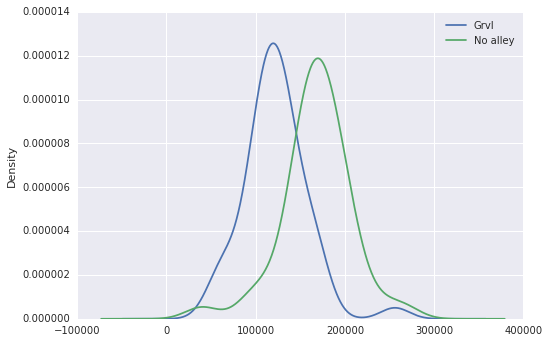

In [145]:
df_train.groupby('Alley')['SalePrice'].plot(kind="density")

plt.legend(labels=['Grvl', 'No alley', 'Pave'])

Alley
Grvl    Axes(0.125,0.125;0.775x0.775)
Pave    Axes(0.125,0.125;0.775x0.775)
Name: Price Per Square Foot, dtype: object

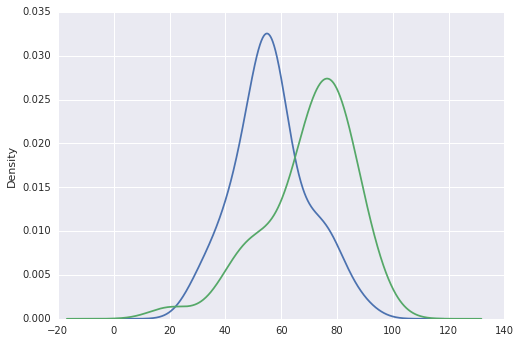

In [146]:
df_train.groupby('Alley')['Price Per Square Foot'].plot(kind="density")

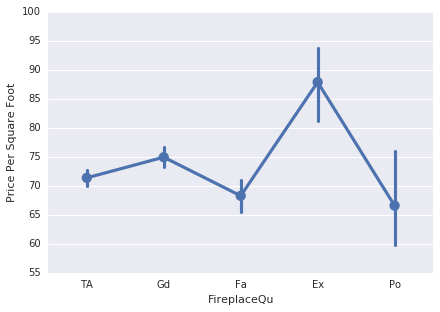

In [147]:
#Ames is very cold so fireplace quantities play important factor
#As expects, the house with excellent rating is in the top pricey house,
#the groups with no or poor fireplace has low average
sns.factorplot('FireplaceQu', 'Price Per Square Foot', estimator = np.mean, data = df_train, 
             size = 4.5, aspect = 1.4)



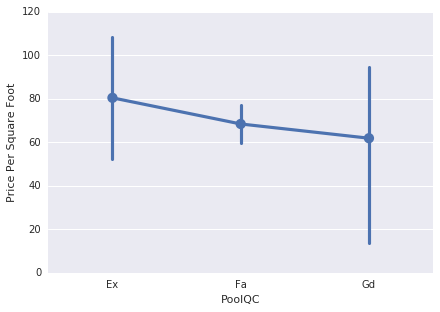

In [148]:
#Did same thing with pool quality, we expect same result but the range for excellent quality is huge
df_train.groupby('PoolQC')['Price Per Square Foot'].describe()

sns.factorplot('PoolQC', 'Price Per Square Foot', estimator = np.mean, data = df_train, 
             size = 4.5, aspect = 1.4)


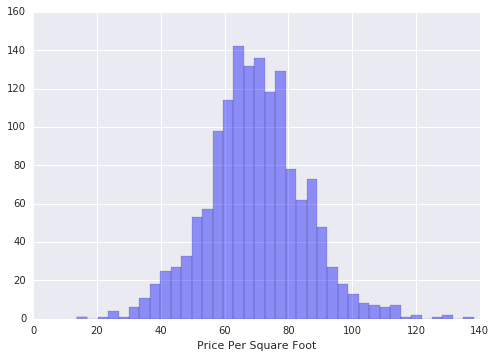

In [149]:
sns.distplot(df_train['Price Per Square Foot'], kde = False, color = "b")

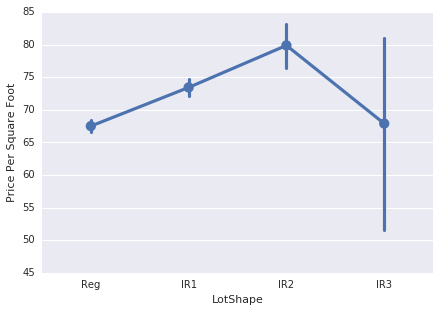

In [150]:
sns.factorplot('LotShape', 'Price Per Square Foot', estimator = np.mean, data = df_train, 
             size = 4.5, aspect = 1.4)

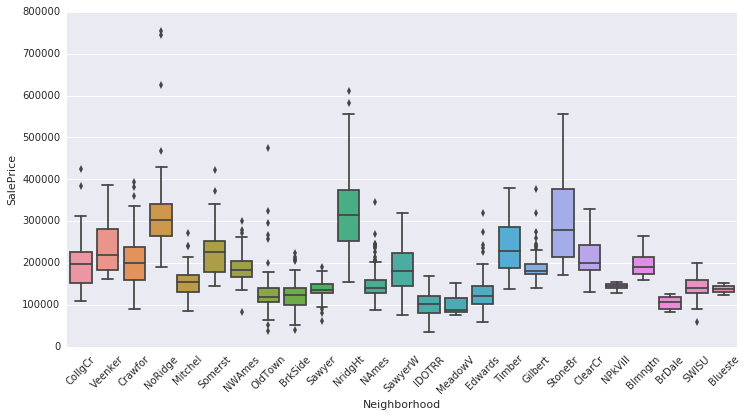

In [151]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Neighborhood', y = 'SalePrice',  data = df_train)
xt = plt.xticks(rotation=45)

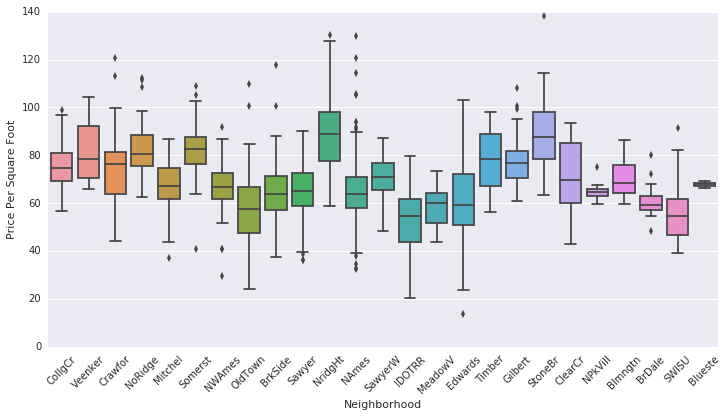

In [152]:
plt.figure(figsize = (12, 6))
sns.boxplot(x = 'Neighborhood', y = 'Price Per Square Foot',  data = df_train)
xt = plt.xticks(rotation=45)

In [153]:
df_train.groupby('Neighborhood')['Price Per Square Foot'].describe()


Neighborhood       
Blmngtn       count     17.000000
              mean      70.713265
              std        8.394542
              min       59.426230
              25%       64.087487
              50%       68.561208
              75%       76.039604
              max       86.336835
Blueste       count      2.000000
              mean      67.867505
              std        1.988720
              min       66.461268
              25%       67.164386
              50%       67.867505
              75%       68.570624
              max       69.273743
BrDale        count     16.000000
              mean      61.004960
              std        7.546897
              min       48.412698
              25%       57.249449
              50%       59.236903
              75%       62.896825
              max       80.272109
BrkSide       count     58.000000
              mean      64.822841
              std       13.038067
              min       37.610619
              25%       56.9

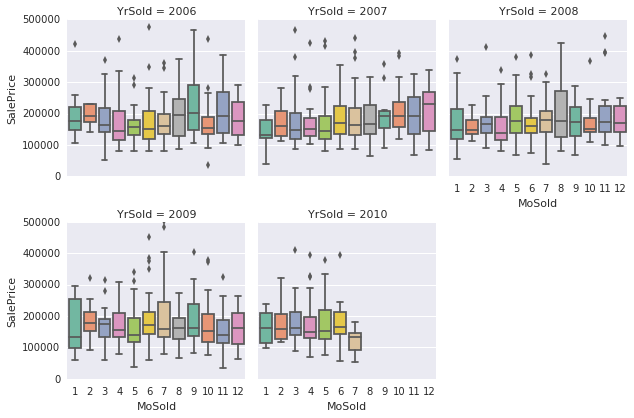

In [154]:
g = sns.FacetGrid(df_train, col = 'YrSold', col_wrap = 3)
g.map(sns.boxplot, 'MoSold', 'SalePrice', palette='Set2', order = range(1, 13))\
.set(ylim = (0, 500000))
plt.tight_layout()


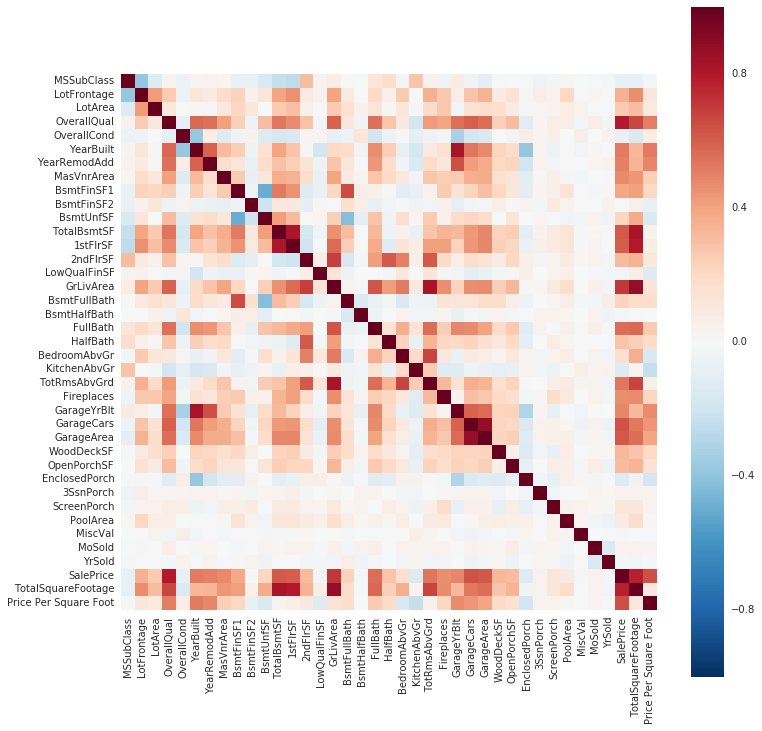

In [155]:
corr = df_train.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1, square=True)

# 